In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
from render_3d_deconv import ValidationRenderer, VALIDATION_PATH_FORMATS
import tqdm

slides = [
    'autostainer',
    '092534',
    '091759',
    '092146',
    '092842',
]

In [10]:
cnn_renderer = ValidationRenderer('autostainer', None, None, VALIDATION_PATH_FORMATS['inception_models'])
cgnn_renderer = ValidationRenderer('autostainer', None, None, VALIDATION_PATH_FORMATS['cells_models'])

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/render_3d_deconv.py:299: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pred_expr_per_cell = [torch.tensor(e) for e in self.validation_data['predictions']['cell_vectors_batch']]


In [20]:
# Create the renderer dict

renderer_dict = {
    slide: {
        method: ValidationRenderer(
            slide, None, None,
            VALIDATION_PATH_FORMATS['inception_models' if method == 'CNN' else 'cells_models']
        )
        for method in ['CNN', 'CGNN']
    }
    for slide in slides
}


Creating ValidationRenderer: autostainer None training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}_validation_results.pt
Creating ValidationRenderer: autostainer None training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}_validation_results.pt


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/render_3d_deconv.py:301: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.boxes = None


Creating ValidationRenderer: 092534 None training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}_validation_results.pt
Creating ValidationRenderer: 092534 None training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}_validation_results.pt


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/cell-detection/render_3d_deconv.py:288: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.cell_detections = torch.load("cell-detections/autostainer_orig/combined_nms.pt")


Creating ValidationRenderer: 091759 None training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}_validation_results.pt
Creating ValidationRenderer: 091759 None training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}_validation_results.pt
Creating ValidationRenderer: 092146 None training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}_validation_results.pt
Creating ValidationRenderer: 092146 None training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}_validation_results.pt
Creating ValidationRenderer: 092842 None training_results_v2/v6_cnn_models_augmented_2_epochs/inception-holding-out-{patient}_validation_results.pt
Creating ValidationRenderer: 092842 None training_results_v2/v7_cell_models_augmented_2_epochs/cellmodel_prior-none_cellreg-enabled_heldout-{patient}_validation_results.pt


In [78]:
render_cache = {}

In [97]:
def render_table(render_slides, render_genes, render_methods, renderer_dict, wtile=1.25, htile=1):
    """
     - render_genes: List of gene symbols, to serve as rows, or "Blank".
     - render_methods: List of {"CNN", "CGNN", "True"}, to serve as columns.
    """
    
    if render_slides == '*':
        render_slides = sorted(renderer_dict.keys())
    
    num_rows = len(render_slides) * len(render_genes)
    num_cols = len(render_methods)
    
    plt.rcParams['figure.figsize'] = (num_cols * wtile, num_rows * htile)
    
    # Returns a Figure and an np.ndarray of Axes
    fig, axs = plt.subplots(num_rows, num_cols + 1)
    
    if num_rows == 1:
        axs = axs[None, :]
    elif num_cols == 1:
        axs = axs[:, None]
        
    plt.subplots_adjust(wspace=0, hspace=0)
    
    row = 0
    with tqdm.tqdm(total=(num_rows * num_cols), desc='Rendering images...') as pbar:
        for gene_i in range(len(render_genes)):
            for slide_i in range(len(render_slides)):
                slide = render_slides[slide_i]
                gene = render_genes[gene_i]

                if slide_i == 0:
                    axs[row][0].text(
                        0.9,
                        0.5,
                        gene + ", " + slide.title(),
                        horizontalalignment = 'right',
                        verticalalignment = 'center',
                        transform = axs[row][0].transAxes
                    )
                else:
                    axs[row][0].text(
                        0.9,
                        0.5,
                        'Patient 1' if slide == 'autostainer' else slide,
                        horizontalalignment = 'right',
                        verticalalignment = 'center',
                        transform = axs[row][0].transAxes
                    )
                axs[row][0].axis('off')

                for col in range(num_cols):
                    method = render_methods[col]
                    cache_key = (slide, method, gene)
                    if cache_key in render_cache:
                        result = render_cache[cache_key]
                    else:
                        if method == 'True':
                            renderer = renderer_dict[slide]['CNN']
                            result = renderer.render_true_visium(gene)
                        elif gene == 'Blank' or method == 'Blank':
                            renderer = renderer_dict[slide]['CNN']
                            result = renderer.blank_image
                        else:
                            renderer = renderer_dict[slide][method]
                            result = renderer.render_predicted_visium(gene)
                        
                        render_cache[cache_key] = result
                        
                    pbar.update()

                    if row == 0:
                        axs[row][col + 1].set_title(method)
                    else:
                        axs[row][col + 1].set_title('')
                    axs[row][col + 1].imshow(result)
                    axs[row][col + 1].axis('off')

                row += 1
                
    plt.tight_layout()
    plt.show()

Rendering images...: 100%|██████████| 20/20 [00:10<00:00,  1.84it/s]


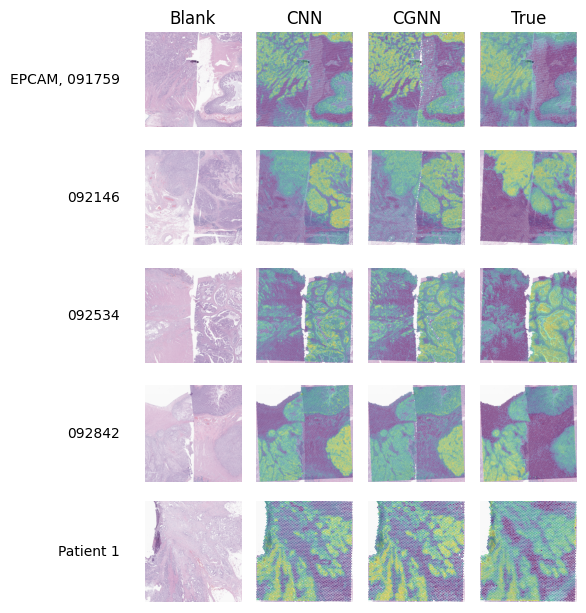

In [114]:
render_table('*', ['EPCAM'], ['Blank', 'CNN', 'CGNN', 'True'], renderer_dict, wtile=1.5, htile=1.25)

In [101]:
# Want to find unique genes? PCA is for you...

from sklearn.decomposition import PCA

pca = PCA(3)
# "method" key doesn't matter, we just need to get to the true_visium
pca.fit(renderer_dict['autostainer']['CNN'].true_visium)
print(pca.components_)


[[ 1.58079452e-03  3.52044845e-02  3.13624706e-02 ...  7.01928316e-04
   3.77074568e-02  3.01093166e-02]
 [ 7.60950662e-02 -1.43642329e-02 -9.32452899e-03 ...  1.99930235e-05
  -1.44894287e-02  5.12944697e-03]
 [ 1.13802693e-01 -3.16144570e-02 -2.19400243e-03 ...  2.66434590e-04
  -7.56908706e-03  3.54443684e-02]]


In [109]:
with open("./training_results_v2/v2_repr_contrastive/genes.txt") as f:
    genes: list = f.read().split("\n")

In [110]:
print(*[genes[gene] for gene in (-pca.components_[0]).argsort()[:10]], sep='\n')

ATP1B1
S100P
AGR2
EPCAM
CD44
GPRC5A
KRT8
LGALS4
PYGB
KLF5


In [111]:
print(*[genes[gene] for gene in (-pca.components_[1]).argsort()[:10]], sep='\n')

TAGLN
ACTA2
MYL9
LUM
IGFBP7
COL1A2
COL1A1
DCN
COL3A1
FN1


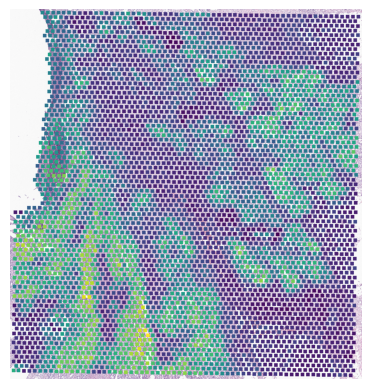

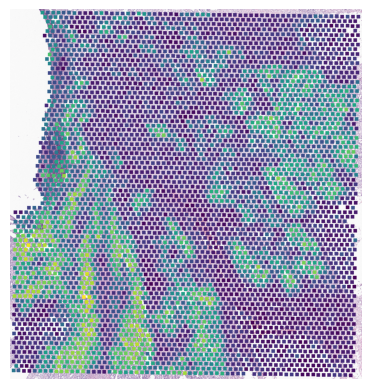

In [31]:
import matplotlib.pyplot as plt

plt.imshow(
    cnn_renderer.render_predicted_visium("CDX2")
)
plt.axis('off')
plt.show()

plt.imshow(
    cgnn_renderer.render_predicted_visium("CDX2")
)
plt.axis('off')
plt.show()